In [1]:
import fastf1
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [2]:
import os
import tempfile
# Use system temp directory for caching
cache_dir = os.path.join(tempfile.gettempdir(), "f1_cache")
os.makedirs(cache_dir, exist_ok=True)

fastf1.Cache.enable_cache(cache_dir)

In [3]:
# load the 2024 Monza session data
session_2024 = fastf1.get_session(2024, 17, "R")
session_2024.load()
laps_2024 = session_2024.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
laps_2024.dropna(inplace=True)

core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No

In [4]:
# covert lap and sector times to seconds
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
        laps_2024[f"{col} (s)"] = laps_2024[col].dt.total_seconds()

In [5]:
Sector_times_2024=laps_2024.groupby("Driver").agg({
    "Sector1Time (s)":"mean",
    "Sector2Time (s)":"mean",
    "Sector3Time (s)":"mean"

}).reset_index()

Sector_times_2024["TotalSectorTime (s)"] = (
    Sector_times_2024["Sector1Time (s)"] +
    Sector_times_2024["Sector2Time (s)"] +
    Sector_times_2024["Sector3Time (s)"]
)


In [7]:
# clean air race pace from racepace.py
clean_air_race_pace = {
    "VER": 93.191067, "HAM": 94.020622, "LEC": 93.418667, "NOR": 93.428600, "ALO": 94.784333,
    "PIA": 93.232111, "RUS": 93.833378, "SAI": 94.497444, "STR": 95.318250, "HUL": 95.345455,
    "OCO": 95.682128,"Kimi":95.682222
}

In [8]:
# quali data from  Azerbaijan GP
qualifying_2025 = pd.DataFrame({
    "Driver": ["VER", "NOR", "PIA", "RUS", "SAI", "ALB", "LEC", "OCO",
               "HAM", "STR", "GAS", "ALO", "HUL",'KIMI'],
    "QualifyingTime (s)": [  
        102.199,  # NOR(1:09.673)
        101.902,  # Ver 
        102.295,  # PIA (1:10.129)
        101.770,    # RUS 
        None,  # Perez
        101.367,  # LEC
        102.967,  # Alo 
        102.167,  # OCO (1:10.942)
        101.293,  # HAM (1:10.382)
        102.771,  # STR (1:12.563)
        102.674,  # GAS (1:11.994)
        102.177,  # albon
        102.820,   # HUL (1:11.596)
        101.779   #kimi
    ]

})
qualifying_2025["CleanAirRacePace (s)"] = qualifying_2025["Driver"].map(clean_air_race_pace)

In [10]:
#get weather data for BAKU
API_KEY = "d2585e28290357a9db05c428cdb49ae9"
weather_url = f"http://api.openweathermap.org/data/2.5/forecast?lat=40.3729&lon=49.8532&appid={API_KEY}&units=metric"
response = requests.get(weather_url)
weather_data = response.json()
forecast_time = "2025-09-19 13:00:00"  # 15:00 CEST local time
forecast_data = next((f for f in weather_data["list"] if f["dt_txt"] == forecast_time), None)
rain_probability = forecast_data["pop"] if forecast_data else 0
temperature = forecast_data["main"]["temp"] if forecast_data else 20



In [11]:
# adjust qualifying time based on weather conditions
if rain_probability >= 0.75:
    qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"] * qualifying_2025["WetPerformanceFactor"]
else:
    qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"]


In [12]:
# add constructor's data
team_points = {
    "McLaren": 584, "Mercedes": 248, "Red Bull": 214, "Williams": 80, "Ferrari": 260,
    "Haas": 44, "Aston Martin": 62, "Kick Sauber": 51, "Racing Bulls": 60, "Alpine": 20
}
max_points = max(team_points.values())
team_performance_score = {team: points / max_points for team, points in team_points.items()}

driver_to_team = {
    "VER": "Red Bull", "NOR": "McLaren", "PIA": "McLaren", "LEC": "Ferrari", "RUS": "Mercedes",
    "HAM": "Mercedes", "GAS": "Alpine", "ALO": "Aston Martin", "TSU": "Racing Bulls",
    "SAI": "Ferrari", "HUL": "Kick Sauber", "OCO": "Alpine", "STR": "Aston Martin"
}

qualifying_2025["Team"] = qualifying_2025["Driver"].map(driver_to_team)
qualifying_2025["TeamPerformanceScore"] = qualifying_2025["Team"].map(team_performance_score)


In [13]:
average_position_change_Baku = {
    "PIA": 11,
    "LEC": 0,
    "RUS": 0,
    "NOR": 6,
    "VER": 1,
    "ALO": 13,
    "ALB": 2,
    "COL": 12,
    "HAM": -8,
    "BEA": -5,
    "HUL": 7,
    "GAS": 4,
    "OCO": -7,
    "SAI": -7
}
qualifying_2025["AveragePositionChange"] = qualifying_2025["Driver"].map(average_position_change_Baku)


In [14]:
# merge qualifying and sector times data
merged_data = qualifying_2025.merge(Sector_times_2024[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
merged_data["RainProbability"] = rain_probability
merged_data["Temperature"] = temperature
merged_data["QualifyingTime"] = merged_data["QualifyingTime"]
valid_drivers = merged_data["Driver"].isin(laps_2024["Driver"].unique())
merged_data = merged_data[valid_drivers]


In [15]:
# define features (X) and target (y)
X = merged_data[[
    "QualifyingTime", "RainProbability", "Temperature", "TeamPerformanceScore", 
    "CleanAirRacePace (s)", "AveragePositionChange"
]]
y = laps_2024.groupby("Driver")["LapTime (s)"].mean().reindex(merged_data["Driver"])


In [16]:
# impute missing values for features
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

In [17]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=37)


In [18]:
# train gradient boosting model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.7, max_depth=3, random_state=37)
model.fit(X_train, y_train)
merged_data["PredictedRaceTime (s)"] = model.predict(X_imputed)

In [19]:
# sort the results to find the predicted winner
final_results = merged_data.sort_values("PredictedRaceTime (s)")
print("\n🏁 Predicted 2025 BAKU GP Winner 🏁\n")
print(final_results[["Driver", "PredictedRaceTime (s)"]])
y_pred = model.predict(X_test)
print(f"Model Error (MAE): {mean_absolute_error(y_test, y_pred):.2f} seconds")


🏁 Predicted 2025 BAKU GP Winner 🏁

   Driver  PredictedRaceTime (s)
2     PIA             108.403469
1     NOR             108.521734
6     LEC             108.607878
0     VER             108.929208
3     RUS             108.979082
8     HAM             110.018918
4     SAI             110.022233
5     ALB             110.075020
11    ALO             110.077531
9     STR             110.091337
12    HUL             110.118367
7     OCO             110.277501
10    GAS             110.332000
Model Error (MAE): 0.71 seconds


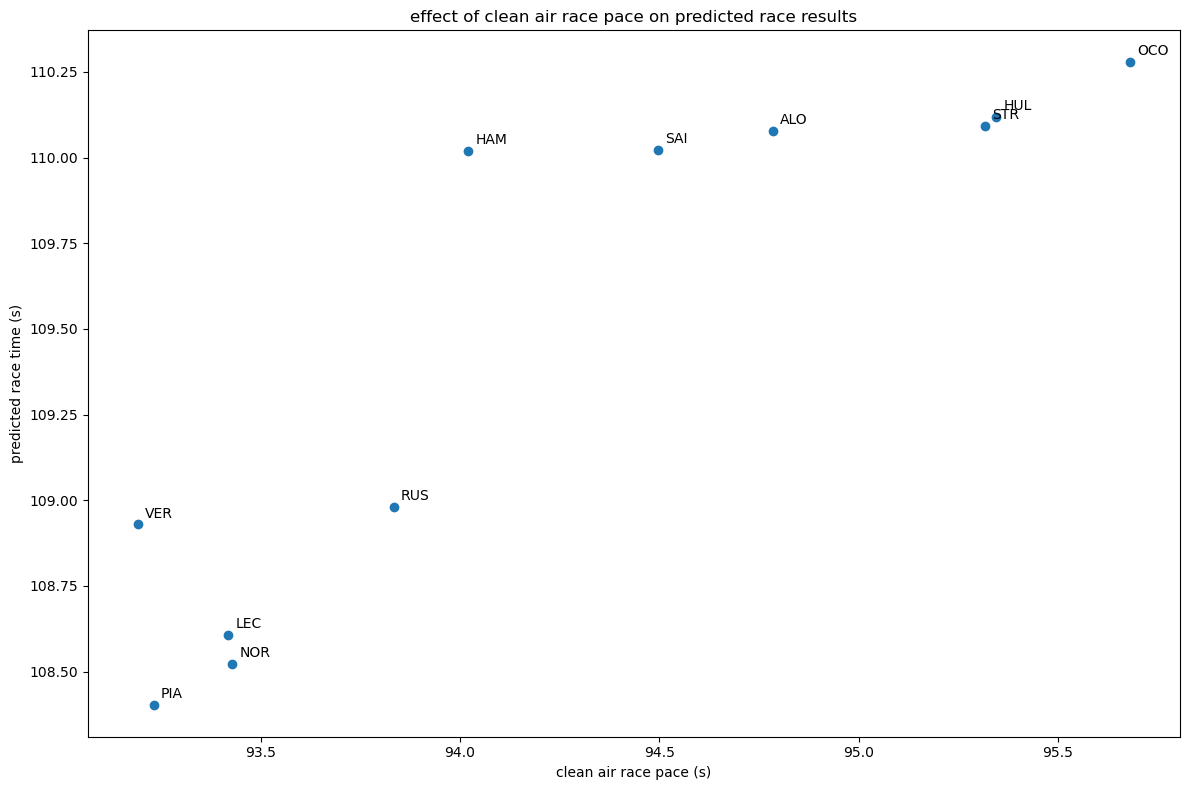

In [20]:
# plot effect of clean air race pace
plt.figure(figsize=(12, 8))
plt.scatter(final_results["CleanAirRacePace (s)"], final_results["PredictedRaceTime (s)"])
for i, driver in enumerate(final_results["Driver"]):
    plt.annotate(driver, (final_results["CleanAirRacePace (s)"].iloc[i], final_results["PredictedRaceTime (s)"].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')
plt.xlabel("clean air race pace (s)")
plt.ylabel("predicted race time (s)")
plt.title("effect of clean air race pace on predicted race results")
plt.tight_layout()
plt.show()

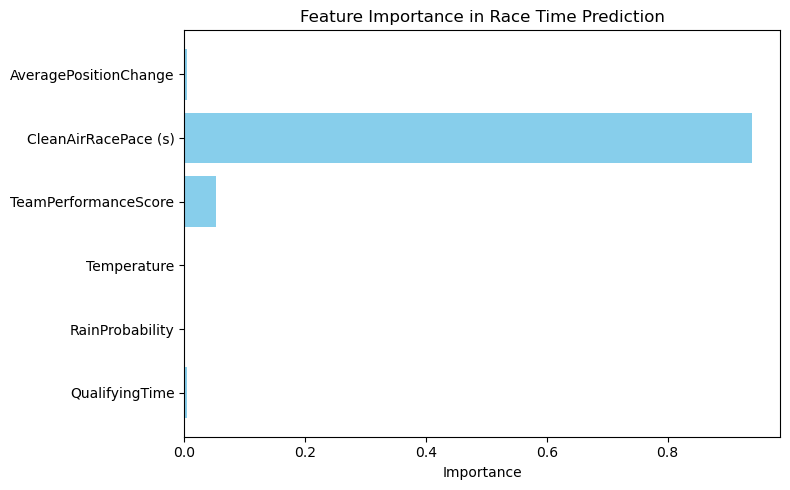

In [21]:
# Plot feature importances
feature_importance = model.feature_importances_
features = X.columns

plt.figure(figsize=(8,5))
plt.barh(features, feature_importance, color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance in Race Time Prediction")
plt.tight_layout()
plt.show()

In [22]:
# sort results and get top 3
final_results = merged_data.sort_values("PredictedRaceTime (s)").reset_index(drop=True)
podium = final_results.loc[:2, ["Driver", "PredictedRaceTime (s)"]]

print("\n🏆 Predicted in the Top 3 🏆")
print(f"🥇 P1: {podium.iloc[0]['Driver']}")
print(f"🥈 P2: {podium.iloc[1]['Driver']}")
print(f"🥉 P3: {podium.iloc[2]['Driver']}")


🏆 Predicted in the Top 3 🏆
🥇 P1: PIA
🥈 P2: NOR
🥉 P3: LEC
